In [5]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os

np.random.seed(1)
torch.manual_seed(1)

# Define Transformer: confined to canonical transformation

'''class T(nn.Module):
    def __init__(self,w=200):
        super(T, self).__init__()
        self.l1 = nn.Linear(int(input_d/2),w)
        self.l2 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,int(input_d/2))
        
    def x_forward(self, xp, eps=0.1):
        x = xp[:,:int(input_d/2)]
        p = xp[:,int(input_d/2):]
        bs = x.shape[0]
        f = nn.Tanh()
        self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        xprime = x + eps*self.x3
        return xprime
    
    def jac_tf(self,xp):
        x = xp[:,:int(input_d/2)]
        p = xp[:,int(input_d/2):]
        jac = torch.autograd.functional.jacobian(self.x_forward,x,create_graph=True)
        jac_t = []
        for i in range(jac.shape[0]):
            jac_t.append(jac[i,:,i,:])
        jac_t = torch.stack(jac_t)
        return jac_t
        
    def forward(self, xp):
        x = xp[:,:int(input_d/2)]
        p = xp[:,int(input_d/2):]
        jac_t = self.jac_tf(xp)
        #print(torch.inverse(jac_t).permute(0,2,1).shape)
        #print(p.shape)
        pprime = torch.matmul(torch.inverse(jac_t).permute(0,2,1), p.unsqueeze(dim=2))[:,:,0]
        xprime = self.x_forward(xp)
        return torch.cat((xprime, pprime),dim=1)
    
    #def forward(self, x, eps=0.0):
    #    return self.l0(x)
    
    def transform_f(self, xp):
        jac_t = self.jac_tf(xp)
        f_ = f(xp)
        fx = f_[:,:int(input_d/2)]
        fp = f_[:,int(input_d/2):]
        fx_prime = torch.matmul(torch.inverse(jac_t).permute(0,2,1), fx.unsqueeze(dim=2))[:,:,0]
        fp_prime = torch.matmul(jac_t, fp.unsqueeze(dim=2))[:,:,0]
        return torch.cat((fx_prime, fp_prime),dim=1)'''


# Define Transformer: not confined to canonical transformation

def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return torch.autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

class T(nn.Module):
    def __init__(self,w=200):
        super(T, self).__init__()
        self.l1 = nn.Linear(input_d,w)
        self.l2 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,input_d)
    
    def forward(self, x, eps=0.1):
        bs = x.shape[0]
        #f = nn.Tanh()
        f = nn.SiLU()
        self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        return x + eps*self.x3
    
    #def forward(self, x, eps=0.0):
    #    return self.l0(x)
    
    def transform_f(self, x):
        jac_ts = batch_jacobian(self.forward, x, create_graph=True)
        return torch.matmul(jac_ts, torch.unsqueeze(f(x), dim=2))

In [6]:
# Loss library

# Lie group: for SO(2), g_J = [[0,1],[-1,0]]

def Jp_(f,t,inputs):
    input_d = input_.shape[1]
    jac_f = batch_jacobian(f,inputs,create_graph=True)
    jac_ts = batch_jacobian(t,inputs,create_graph=True)
    jac_inv_ts = torch.inverse(jac_ts)

    # get Hessian of t
    gradsss = []
    for i in range(input_d):
        gradss = []
        for j in range(input_d):
            grads = torch.autograd.grad(jac_ts[:,i,j], inputs, torch.ones_like(jac_ts[:,i,j]), create_graph=True, retain_graph=True)[0]
            gradss.append(grads)
        gradss = torch.stack(gradss)
        gradsss.append(gradss)
    # SHAPE
    hess_t = torch.stack(gradsss).permute(2,0,1,3)

    # calculate J'
    Jp1 = jac_inv_ts.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=4)*hess_t.permute(0,2,1,3).unsqueeze(dim=2)*f(inputs).unsqueeze(dim=1).unsqueeze(dim=2).unsqueeze(dim=3)
    Jp2 = jac_inv_ts.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=4)*jac_ts.unsqueeze(dim=2).unsqueeze(dim=3)*jac_f.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=2)
    Jp = Jp1 + Jp2
    Jp = torch.sum(torch.sum(Jp,dim=4),dim=3)
    return Jp

def hess(t, inputs):
    jac_ts = batch_jacobian(t,inputs,create_graph=True)
    
    # get Hessian of t
    gradsss = []
    for i in range(input_d):
        gradss = []
        for j in range(input_d):
            grads = torch.autograd.grad(jac_ts[:,i,j], inputs, torch.ones_like(jac_ts[:,i,j]), create_graph=True, retain_graph=True)[0]
            gradss.append(grads)
        gradss = torch.stack(gradss)
        gradsss.append(gradss)
    # SHAPE
    hess_t = torch.stack(gradsss).permute(2,0,1,3)
    
    return hess_t
    

def off_diag(M,n_part=[2,2]):
    bs = M.shape[0]
    input_d = M.shape[1]
    assert input_d == np.sum(n_part)
    start = 0
    end = n_part[0]
    diag_loss = 0
    for i in range(len(n_part)):
        diag_loss = diag_loss + torch.sum(M[:,start:end, start:end]**2)
        start = end
        end = end + n_part[i]
    return (torch.sum(M**2) - diag_loss)/(batch_size*input_d**2)


def lie_loss(f,t,inputs):
    
    bs = inputs.shape[0]
    # for SO(2)
    g_J = torch.tensor([[0,1],[-1,0]], dtype=torch.float, requires_grad=True)
    Jp = Jp_(f,t,inputs)
    fp = t.transform_f(inputs)
    inputsp = torch.unsqueeze(t(inputs), dim=2)
    
    g_J = torch.unsqueeze(torch.unsqueeze(torch.ones(bs,),dim=1),dim=1) * torch.unsqueeze(g_J, dim=0)
    pde = torch.matmul(torch.matmul(Jp.permute(0,1,2),g_J),inputsp) - torch.matmul(g_J, fp)
    r_mse = torch.mean(inputsp**2)
    loss = torch.mean(pde**2)
    return loss/r_mse

def translation_loss(f,t,inputs):
    Jp = Jp_(f,t,inputs)[:,0]
    loss = torch.mean(Jp**2)
    return loss

def modularity_loss(f,t,inputs,n_part=[2,2]):
    Jp = Jp_(f,t,inputs)
    loss = off_diag(Jp,n_part=n_part)
    return loss

def hamiltonicity_loss(f,t,inputs):
    Jp = Jp_(f,t,inputs)
    input_d = inputs.shape[1]
    assert input_d % 2 ==0
    M = torch.zeros(input_d, input_d)
    half_d = int(input_d/2)
    M[:half_d, half_d:] = torch.eye(half_d)
    M[half_d:, :half_d] = -torch.eye(half_d)
    M = torch.tensor(M, dtype=torch.float, requires_grad=True)
    JMMJ = torch.matmul(Jp.permute(0,2,1), M) + torch.matmul(M, Jp)
    loss = torch.mean(JMMJ**2)
    return loss

In [7]:
def canonical_lie_loss(f,t,inputs):
    
    bs = inputs.shape[0]
    # for SO(2)
    g_J = torch.tensor([[0,1],[-1,0]], dtype=torch.float, requires_grad=True)
    Jp = Jp_(f,t,inputs)
    Jp_xx, Jp_xp, Jp_px, Jp_pp = Jp[:,:2,:2], Jp[:,:2,2:], Jp[:,2:,:2], Jp[:,2:,2:]
    fp = t.transform_f(inputs)
    fp_p = fp[:,2:]
    fp_x = fp[:,:2]
    inputsp = torch.unsqueeze(t(inputs), dim=2)
    inputsp_x, inputsp_p = inputsp[:,:2], inputsp[:,2:]
    
    g_J = torch.unsqueeze(torch.unsqueeze(torch.ones(bs,),dim=1),dim=1) * torch.unsqueeze(g_J, dim=0)
    
    #pde_p = torch.matmul(torch.matmul(Jp_px.permute(0,1,2),g_J),inputsp_x) + torch.matmul(torch.matmul(Jp_pp.permute(0,1,2),g_J),inputsp_p) - torch.matmul(g_J, fp_p.unsqueeze(dim=2))
    
    #pde_x = torch.matmul(torch.matmul(Jp_xx.permute(0,1,2),g_J),inputsp_x) + torch.matmul(torch.matmul(Jp_xp.permute(0,1,2),g_J),inputsp_p) - torch.matmul(g_J, fp_x.unsqueeze(dim=2))
    pde_p = torch.matmul(torch.matmul(Jp_px.permute(0,1,2),g_J),inputsp_x) + torch.matmul(torch.matmul(Jp_pp.permute(0,1,2),g_J),inputsp_p) - torch.matmul(g_J, fp_p)
    
    pde_x = torch.matmul(torch.matmul(Jp_xx.permute(0,1,2),g_J),inputsp_x) + torch.matmul(torch.matmul(Jp_xp.permute(0,1,2),g_J),inputsp_p) - torch.matmul(g_J, fp_x)
    r_mse = torch.mean(inputsp**2)
    loss = torch.mean(pde_p**2+pde_x**2)
    return loss/r_mse

In [8]:
from celluloid import Camera
fig = plt.figure(figsize=(15,5))
camera = Camera(fig)


# Training a transformer to minimize PDE losses

# Define Force Field

losses = []

b = 1
a = -2
c = 0.1

'''def x2xp(x):
    y = torch.ones_like(x)
    y[:,0] = x[:,0]
    y[:,1] = x[:,1]
    y[:,2] = x[:,2]
    y[:,3] = x[:,3]
    return y


def f(x):
    r = torch.sqrt(x[:,0]**2 + x[:,1]**2)
    return torch.transpose(torch.stack([x[:,2],x[:,3],-x[:,0]*r**(a-1)/b,-x[:,1]*r**(a-1)*b]),0,1)
'''

def x2xp(x):
    y = torch.ones_like(x)
    y[:,0] = (np.e**(c*x[:,0])-1)/c
    y[:,1] = (np.e**(c*x[:,1])-1)/c
    y[:,2] = (np.e**(c*x[:,2])-1)/c
    y[:,3] = (np.e**(c*x[:,3])-1)/c
    return y

def f(x):
    return torch.transpose(torch.stack([(c*x[:,0]+1)*torch.log(c*x[:,2]+1)/c,(c*x[:,1]+1)*torch.log(c*x[:,3]+1)/c,-(1+c*x[:,2])*torch.log(1+c*x[:,0])/(1/(c**2)*(torch.log(1+c*x[:,0])**2+torch.log(1+c*x[:,1])**2)**(3/2)),-(1+c*x[:,3])*torch.log(1+c*x[:,1])/(1/(c**2)*(torch.log(1+c*x[:,0])**2+torch.log(1+c*x[:,1])**2)**(3/2))]),0,1)


input_grid = 4*torch.rand(2000,4, requires_grad=True)-2
select = (torch.sqrt(input_grid[:,0]**2 + input_grid[:,1]**2)>1.0)
input_grid = input_grid[select]
input_ = x2xp(input_grid)
input_d = input_.shape[1]


np.random.seed(0)
torch.manual_seed(0)

t = T(w=400)
epochs = 5000
switch_epoch = 1000
lr_decay_epoch = 500

n_train = input_.shape[0]
batch_size = 128

lr = 1e-3
optimizer = optim.Adam(t.parameters(), lr=lr)

log = 10

losses_ham = []
losses_mod = []

for epoch in range(epochs):

    t.train()
    optimizer.zero_grad()

    choices = np.random.choice(n_train, batch_size)
    inputs = input_[choices]

    if epoch == switch_epoch:
        for opt_param in optimizer.param_groups:
            lr = 1e-3
            opt_param['lr'] = lr
    
    if (epoch+1) % lr_decay_epoch == 0:
        for opt_param in optimizer.param_groups:
            lr = lr * 0.5
            opt_param['lr'] = lr
    '''loss_ham = hamiltonicity_loss(f,t,inputs)
    loss = loss_ham

    losses_ham.append(loss_ham.detach().numpy())
    #loss.backward(retain_graph=True)'''
    
    if epoch < switch_epoch:
        loss_ham = hamiltonicity_loss(f,t,inputs)
        loss_mod = float("nan")
        losses_ham.append(loss_ham.detach().numpy())
        losses_mod.append(loss_mod)
        loss = loss_ham
    else:
        loss_ham = hamiltonicity_loss(f,t,inputs)
        loss_mod = canonical_lie_loss(f,t,inputs)
        losses_ham.append(loss_ham.detach().numpy())
        losses_mod.append(loss_mod.detach().numpy())
        loss = loss_ham + loss_mod
        
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch%log == 0:
        print('Epoch:  %d | Loss_ham: %.4f | Loss_lie: %.4f ' %(epoch, loss_ham, loss_mod))
losses.append(loss.detach().numpy())

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  0 | Loss_ham: 0.0041 | Loss_lie: nan 
Epoch:  10 | Loss_ham: 0.0006 | Loss_lie: nan 
Epoch:  20 | Loss_ham: 0.0002 | Loss_lie: nan 
Epoch:  30 | Loss_ham: 0.0001 | Loss_lie: nan 
Epoch:  40 | Loss_ham: 0.0001 | Loss_lie: nan 
Epoch:  50 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  60 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  70 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  80 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  90 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  100 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  110 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  120 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  130 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  140 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  150 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  160 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  170 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  180 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  190 | Loss_ham: 0.0000 | Loss_lie: nan 
Epoch:  200 | Loss_ham: 0.0000 | Loss_lie: nan 
Epo

Epoch:  1650 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1660 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1670 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1680 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1690 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1700 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1710 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1720 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1730 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1740 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1750 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1760 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1770 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1780 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1790 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1800 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1810 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1820 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1830 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  1840

Epoch:  3220 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3230 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3240 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3250 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3260 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3270 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3280 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3290 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3300 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3310 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3320 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3330 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3340 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3350 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3360 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3370 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3380 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3390 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3400 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  3410

Epoch:  4790 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4800 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4810 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4820 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4830 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4840 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4850 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4860 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4870 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4880 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4890 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4900 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4910 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4920 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4930 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4940 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4950 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4960 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4970 | Loss_ham: 0.0000 | Loss_lie: 0.0000 
Epoch:  4980

<Figure size 1080x360 with 0 Axes>

In [9]:
np.save('./results/2d_kepler.npy', np.array([losses_ham, losses_mod]))
loss = np.load('./results/2d_kepler.npy')
losses_ham = loss[0]
losses_mod = loss[1]

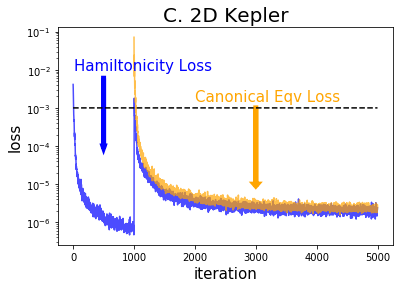

In [27]:
# hamiltonicity, symplectic equivariance
plt.plot(np.arange(epochs),np.array(losses_ham), alpha=0.7,color="blue")
plt.plot(np.arange(epochs),np.array(losses_mod), alpha=0.7,color="orange")

plt.arrow(500,0.006,0,-0.0059,head_width=20,head_length=0.00001,linewidth=5,color="blue")
plt.text(10, 0.01, "Hamiltonicity Loss", fontsize=15, color="blue")

plt.arrow(3000,0.001,0,-0.00099,head_width=50,head_length=0.000001,linewidth=5,color="orange")
plt.text(2000, 0.0015, "Canonical Eqv Loss", fontsize=15, color="orange")

plt.xlabel("iteration",fontsize=15)
plt.ylabel("loss",fontsize=15)
#plt.title("modularity_loss",fontsize=15)
#plt.legend(["hamiltonicity_loss", "symplectic_rotation_loss"])
plt.plot(np.arange(epochs), np.ones(epochs,)*1e-3, ls="--", color="black")
plt.title('C. 2D Kepler',fontsize=20)
plt.yscale('log')
plt.savefig('./figures/2d_kepler.pdf', bbox_inches="tight")

In [288]:
np.save('./results/2d_kepler.npy', np.array([np.array(losses_ham),np.array(losses_mod)]))